In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import scipy as sp
from scipy import interpolate
import random
import pandas as pd
import warnings
from cycler import cycler
from siggen_pulses import *
from oneshot import *

%matplotlib inline

In [ ]:
print(plt.rcParams)

In [2]:
# Plotting settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana',
                                   'Computer Modern Sans Serif',
                                   'DejaVu Sans',
                                   'Bitstream Vera Sans',
                                   'Lucida Grande',
                                   'Geneva',
                                   'Lucid',
                                   'Arial',
                                   'Helvetica',
                                   'Avant Garde',
                                   'sans-serif']
plt.rcParams['font.size'] = 20
plt.rcParams['axes.prop_cycle'] = (cycler(color=['r', 'g', 'b', 'y']) + 
                                   cycler(linestyle=['-', '--', ':', '-.']))
# font = {'family': 'sans-serif',
#         'fantasy': 'xkcd',
# #         'sans-serif': 'arial',
#        'weight':'normal',
#        'size':20}
# rc('font', **font)

# matplotlib.rc('xtick', labelsize=20)
# matplotlib.rc('ytick', labelsize=20)

<h1>ToF Histogram</h1>

In [ ]:
file_name = '../data/tofs.csv'
tof_col_name = 'TOF[ns]'
mq_names = ['MQ{0}'.format(x) for x in (1,2,4,14,16,18,20,28,29,30,38,39,40)]
# data = pd.read_csv(file_name)
data_dict = parse_tof_histogram(file_name, tof_col_name, mq_names)

In [ ]:
data = pd.read_csv(file_name)
times = list(data[tof_col_name])
mq_distrib_dict = {mq:data[mq] for mq in mq_names}

In [ ]:
# Settings
ylim = (0, 1.1)
xlim = (min(times), 150)
figsize = (20, 10)
mq_styles = ['r-', 'g.']

# Plotting
fig, ax = plt.subplots(figsize=figsize)
for i, mq in enumerate(mq_names):
    # Histograms
    mq_value = mq.replace('MQ', '')
    mq_label = f'MQ = {mq_value}'
    mq_distrib = mq_distrib_dict[mq]
    ax.plot(times, mq_distrib, label=mq_label)
    
    # Annotate peak of histogram with MQ
#     mq_annot = mq
#     idx_peak = np.argmax(mq_distrib)
#     y_peak = max(mq_distrib)
#     x_peak = times[idx_peak]
#     loc_annot = (x_peak, y_peak*1.05)
#     ax.annotate(s=mq_annot, xy=loc_annot)
    
ax.legend()
ax.set_xlabel('Time of Flight [ns]')
ax.set_title('Normalized Ion Distributions')
ax.grid(True)
ax.set_ylim(ylim)
ax.set_xlim(xlim);

<h1>One-Shot Results Statistics</h1>

In [6]:
file_name = '../data/data_1nsPulse_randPeriod_R20kC1p_noReset.csv'
data_dict = parse_pulse(file_name)

pulse_widths_spec = dict(data_dict = data_dict,
                        sig_threshold = 1.65,
                        posedge = True)

pulse_width_list = get_pulse_widths(**pulse_widths_spec)

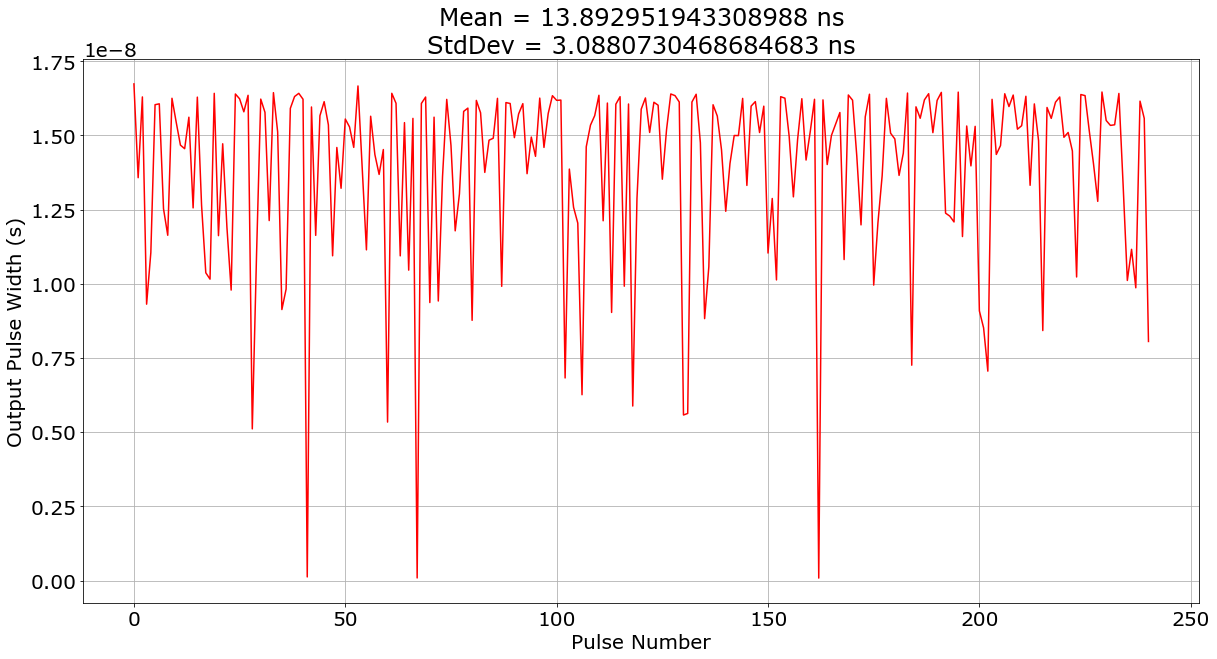

In [7]:
# Plotting
figsize = (20, 10)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(pulse_width_list)

ax.set_xlabel('Pulse Number')
ax.set_ylabel('Output Pulse Width (s)')
ax.set_title(f'Mean = {np.average(pulse_width_list)*1e9} ns\nStdDev = {np.std(pulse_width_list)*1e9} ns')
ax.grid(True)

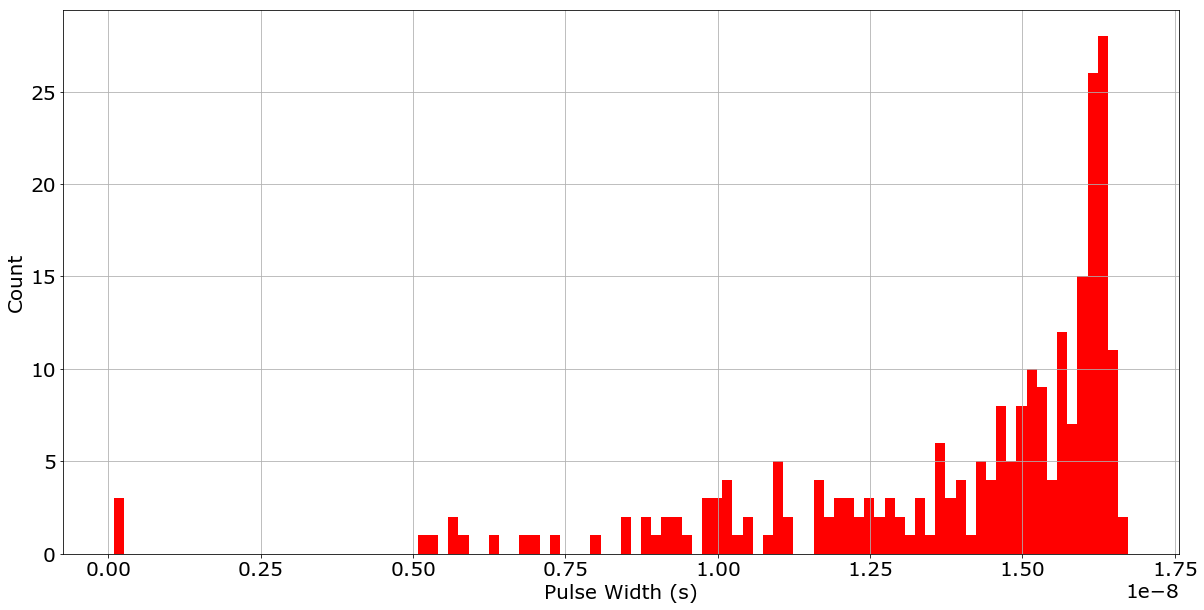

In [8]:
# Histogram
figsize = (20, 10)

fig, ax = plt.subplots(figsize=figsize)
ax.hist(pulse_width_list, bins=100)
ax.set_xlabel('Pulse Width (s)')
ax.set_ylabel('Count')
ax.grid(True)